In [1]:
import pickle
import pandas as pd
from datetime import datetime
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [9]:
pickle_off = open("finance_dataset.pkl","rb")
df = pickle.load(pickle_off)

In [10]:
df.columns

Index(['Headline', 'Journalists', 'Date', 'Link', 'Article'], dtype='object')

In [11]:
df.head()

,Headline,Journalists,Date,Link,Article
0,Exxon Mobil offers plan to end Alaska dispute,[Yereth Rosen],"Fri Oct 20, 2006 6:15pm EDT",http://www.reuters.com/article/2006/10/20/busi...,"ANCHORAGE, Alaska (Reuters) - Exxon Mobil ( X..."
1,"Hey buddy, can you spare $600 for a Google share?","[Paul Thomasch, Eric Auchard]","Fri Oct 20, 2006 4:25pm EDT",http://www.reuters.com/article/2006/10/20/busi...,SAN FRANCISCO/NEW YORK (Reuters) - Wall Stree...
2,AOL CEO says sales may shrink for two years -p...,[],"Sat Oct 21, 2006 2:21pm EDT",http://www.reuters.com/article/2006/10/21/busi...,FRANKFURT (Reuters) - Internet service provid...
3,"Fed to keep hawkish tone, hold rates steady",[Alister Bull],"Sun Oct 22, 2006 12:14pm EDT",http://www.reuters.com/article/2006/10/22/busi...,WASHINGTON (Reuters) - The central bank is ex...
4,Pluspetrol says losing $2.4 mln/day in Peru pr...,[],"Sat Oct 21, 2006 8:11pm EDT",http://www.reuters.com/article/2006/10/22/busi...,"LIMA, Peru (Reuters) - Argentine oil company ..."


In [12]:
df.drop(['Journalists','Link','Article'], axis=1, inplace = True)

In [13]:
df_stock = pd.read_csv("AMZN.csv")
df_stock.drop(df_stock.index[:2], inplace=True)

In [14]:
df_stock.head()
dates = df_stock['Date'] 

In [16]:
df_stock.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
496,2013-11-12,352.989990,355.480011,347.279999,349.529999,349.529999,2343100
497,2013-11-13,347.399994,356.220001,345.679993,356.220001,356.220001,2773300
498,2013-11-14,357.390015,368.940002,356.429993,367.399994,367.399994,4159800
499,2013-11-15,367.630005,372.899994,365.549988,369.170013,369.170013,4491600
500,2013-11-18,370.279999,373.489990,364.670013,366.179993,366.179993,2737400


In [17]:
date_list, modified_list, final_list = [], [], []
for date in df['Date']:
    date_list = date.split(" ")
    st = " ".join(date_list[0:5])
    modified_list.append(st)


for date in modified_list:
    obj =datetime.strptime(date, '%a %b %d, %Y %I:%M%p')
    ls2 = obj.strftime('%Y-%m-%d')
    final_list.append(ls2)
final_list[0:4]


['2006-10-20', '2006-10-20', '2006-10-21', '2006-10-22']

In [18]:
df.drop(['Date'], axis=1, inplace = True)

In [19]:
df['Date'] = final_list
df.head()

,Headline,Date
0,Exxon Mobil offers plan to end Alaska dispute,2006-10-20
1,"Hey buddy, can you spare $600 for a Google share?",2006-10-20
2,AOL CEO says sales may shrink for two years -p...,2006-10-21
3,"Fed to keep hawkish tone, hold rates steady",2006-10-22
4,Pluspetrol says losing $2.4 mln/day in Peru pr...,2006-10-21


In [20]:
news_needed = []
missing_dates = []
for date in list(dates):
    if date in list(df['Date']):
        news_needed.append(list(df[df['Date'] == date].Headline)[0])
    else:
        missing_dates.append(date)

In [21]:
missing_dates

['2013-08-12', '2013-08-22']

In [22]:
#As these dates are missing in news dataset, we will delete them from stock dataset too:
df_stock.drop( df_stock[ df_stock['Date'] == '2013-08-12' ].index , inplace=True)
df_stock.drop( df_stock[ df_stock['Date'] == '2013-08-22' ].index , inplace=True)

In [23]:
#Now I have main news headline for the day, however I don't have its label.
#To label my dataset, I used another dataset where it was labeled feature if the news are positive(1) or negative(0) on that day

In [24]:
df_news = pd.read_csv("news.csv")
df_news.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [25]:
news_labels = []
for date in list(dates):
    if date in list(df_news['Date']):
        news_labels.append(list(df_news[df_news['Date'] == date].Label))

In [26]:
clean_news_labels = []
for i in news_labels:
    clean_news_labels.append(i[0])

In [27]:
#Create final news dataframe:
final_news_df = pd.DataFrame(list(zip(news_needed, clean_news_labels)), 
               columns =['News', 'Label'])

In [28]:
df_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
2,2011-11-23,193.059998,194.600006,187.889999,188.990005,188.990005,8011300
3,2011-11-25,190.410004,190.830002,181.509995,182.399994,182.399994,4972000
4,2011-11-28,191.649994,194.619995,190.539993,194.149994,194.149994,7207300
5,2011-11-29,194.779999,195.500000,187.300003,188.389999,188.389999,6575100
6,2011-11-30,194.759995,195.300003,188.750000,192.289993,192.289993,7717000


In [29]:
#STock price dataset:

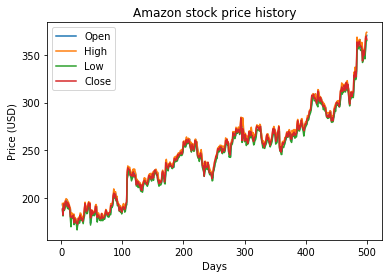

In [30]:

plt.figure()
plt.plot(df_stock["Open"])
plt.plot(df_stock["High"])
plt.plot(df_stock["Low"])
plt.plot(df_stock["Close"])
plt.title('Amazon stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

In [31]:
#combine datasets:
df_stock['Label'] = list(final_news_df['Label'])

In [32]:
df_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Label
2,2011-11-23,193.059998,194.600006,187.889999,188.990005,188.990005,8011300,0
3,2011-11-25,190.410004,190.830002,181.509995,182.399994,182.399994,4972000,0
4,2011-11-28,191.649994,194.619995,190.539993,194.149994,194.149994,7207300,1
5,2011-11-29,194.779999,195.500000,187.300003,188.389999,188.389999,6575100,1
6,2011-11-30,194.759995,195.300003,188.750000,192.289993,192.289993,7717000,1


In [33]:
df_stock["Close"]=pd.to_numeric(df_stock.Close,errors='coerce')

In [34]:
df_stock.drop(['Date','Adj Close', 'Volume'], inplace=True, axis=1)

In [36]:
df_stock.head()

,Open,High,Low,Close,Label
2,193.059998,194.600006,187.889999,188.990005,0
3,190.410004,190.830002,181.509995,182.399994,0
4,191.649994,194.619995,190.539993,194.149994,1
5,194.779999,195.500000,187.300003,188.389999,1
6,194.759995,195.300003,188.750000,192.289993,1


In [37]:
train_set =df_stock.iloc[:377, :]
test_set = df_stock.iloc[377:, :]

In [38]:
train_open= train_set.iloc[:, 0:1].values

In [39]:
#Scaling:
scaler = MinMaxScaler(feature_range=(0,1))
train_open_scaled= scaler.fit_transform(train_open)

In [40]:
X_train = []
y_train = []

for i in range(60,len(train_open_scaled)):
    X_train.append(train_open_scaled[i-60:i,0])
    y_train.append(train_open_scaled[i,0])

X_train,y_train = np.array(X_train),np.array(y_train)

In [41]:
X_train= np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))


In [42]:
X_train.shape


(317, 60, 1)

In [43]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)) #adding the batch_size axis
X_train.shape

(317, 60, 1)

In [44]:
regression= Sequential()

regression.add(LSTM(units=50,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(X_train.shape[1],1)))
regression.add(Dropout(0.2))


regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

regression.add(LSTM(units=50,kernel_initializer='glorot_uniform'))
regression.add(Dropout(0.2))


regression.add(Dense(units=1))


regression.compile(optimizer='adam',loss='mean_squared_error')
regression.fit(X_train,y_train,batch_size=30,epochs=100)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/100





317/317 [==============================] - 14s 44ms/step - loss: 0.1615
Epoch 2/100
317/317 [==============================] - 5s 17ms/step - loss: 0.0294
Epoch 3/100
317/317 [==============================] - 6s 18ms/step - loss: 0.0235
Epoch 4/100
317/317 [==============================] - 10s 33ms/step - loss: 0.0195
Epoch 5/100
317/317 [==============================] - 10s 31ms/step - loss: 0.0162
Epoch 6/100
317/317 [==============================] - 9s 29ms/step - loss: 0.0126
Epoch 7/100
317/317 [==============================] - 9s 28ms/step - loss: 0.0140
Epoch 8/100
317/317 [==============================] - 11s 35ms/step - loss: 0.0132
Epoch 9/100
317/317 [==============================] - 10s 31ms/step - loss: 0.0138
Epoch 10/100
317/317 [====

Epoch 60/100
317/317 [==============================] - 6s 18ms/step - loss: 0.0084
Epoch 61/100
317/317 [==============================] - 6s 19ms/step - loss: 0.0082
Epoch 62/100
317/317 [==============================] - 6s 18ms/step - loss: 0.0087
Epoch 63/100
317/317 [==============================] - 6s 20ms/step - loss: 0.0076
Epoch 64/100
317/317 [==============================] - 6s 20ms/step - loss: 0.0080
Epoch 65/100
317/317 [==============================] - 7s 21ms/step - loss: 0.0078
Epoch 66/100
317/317 [==============================] - 6s 19ms/step - loss: 0.0072
Epoch 67/100
317/317 [==============================] - 6s 20ms/step - loss: 0.0079
Epoch 68/100
317/317 [==============================] - 6s 20ms/step - loss: 0.0071
Epoch 69/100
317/317 [==============================] - 6s 20ms/step - loss: 0.0080
Epoch 70/100
317/317 [==============================] - 7s 21ms/step - loss: 0.0076
Epoch 71/100
317/317 [==============================] - 6s 20ms/step - loss:

In [46]:
test_open= test_set.iloc[:, 0:1].values #taking  open price
total= pd.concat([train_set['Open'],test_set['Open']],axis=0) # Concating train and test and then will take last 60 train point
test_input = total[len(total)-len(test_set)-60:].values
test_input= test_input.reshape(-1,1) # reshaping it to get it transformed
test_input= scaler.transform(test_input)

In [47]:
len(test_input)

180

In [48]:
xtest= []
for i in range(60,80):
    xtest.append(test_input[i-60:i,0]) #creating input for lstm prediction

In [49]:
xtest= np.array(xtest)


In [50]:
xtest

array([[0.8386474 , 0.91433078, 0.92974782, ..., 0.79598802, 0.79038199,
        0.84845841],
       [0.91433078, 0.92974782, 0.91520679, ..., 0.79038199, 0.84845841,
        0.83952341],
       [0.92974782, 0.91520679, 0.92309041, ..., 0.84845841, 0.83952341,
        0.84171332],
       ...,
       [0.78074634, 0.84267702, 0.85283823, ..., 0.95882961, 0.97792582,
        0.92431689],
       [0.84267702, 0.85283823, 0.81271895, ..., 0.97792582, 0.92431689,
        0.91932383],
       [0.85283823, 0.81271895, 0.81026626, ..., 0.92431689, 0.91932383,
        0.89059224]])

In [51]:
xtest= np.reshape(xtest,(xtest.shape[0],xtest.shape[1],1))
predicted_value= regression.predict(xtest)

In [52]:
predicted_value= scaler.inverse_transform(predicted_value)


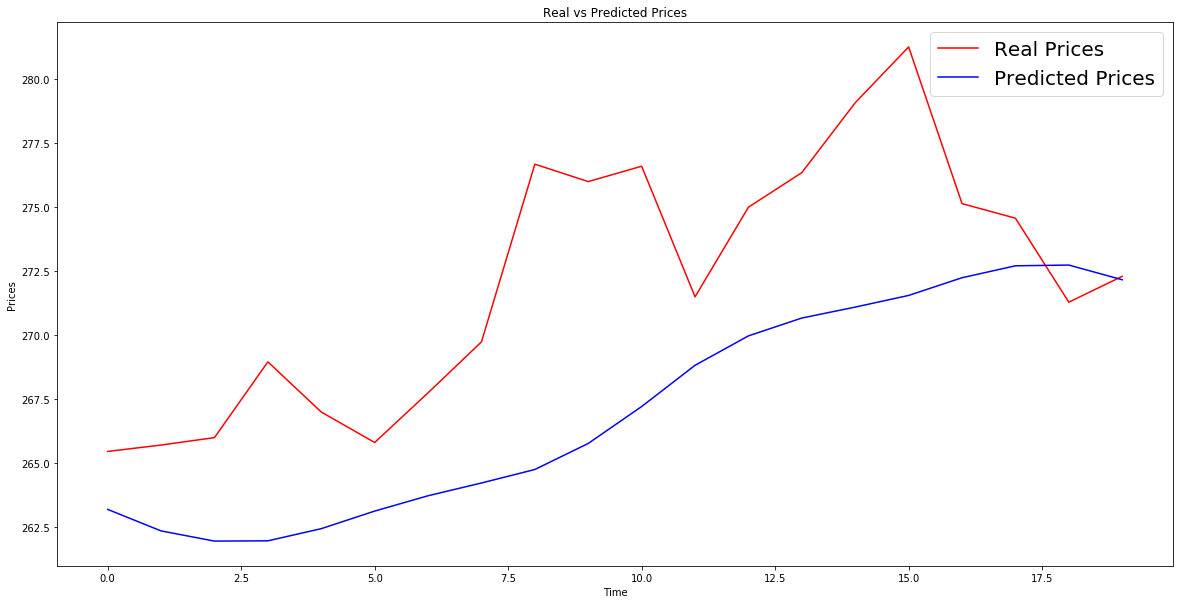

In [53]:
plt.figure(figsize=(20,10))
plt.plot(test_open[0:20],'red',label='Real Prices')
plt.plot(predicted_value,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)